In [1]:
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [2]:
# Load dataset
df = pd.read_csv("SavvySips_FullDataset.csv")

In [3]:
df.head()

,brew_batch_id,ingredient_name,ingredient_category,beer_style,launch_date,customer_segment,approval_rating,units_sold,distribution_regions,repeat_purchase_rate,marketing_spend,social_media_engagement
0,BATCH_0001,Coconut,Nutty,Stout,2023-01-01,Neutral,52,4761,18,81.7,14699,2143
1,BATCH_0002,Mint,Herbal,Lager,2023-01-02,Adventurous,67,8148,8,86.8,16376,4297
2,BATCH_0003,Lavender,Floral,IPA,2023-01-03,Traditionalist,96,5615,8,92.4,18680,3596
3,BATCH_0004,Mint,Herbal,IPA,2023-01-04,Adventurous,99,5137,7,56.1,8745,878
4,BATCH_0005,Mint,Herbal,Sour,2023-01-05,Adventurous,88,5354,8,93.8,7714,313


In [4]:
# Feature engineering
df['IAI'] = df.groupby(['ingredient_name', 'beer_style'])['approval_rating'].transform('mean')
df['MPR'] = df['distribution_regions'] / df['distribution_regions'].max() * 100
df['RPR'] = df['repeat_purchase_rate']

# Select features and target
features = ['ingredient_name', 'ingredient_category', 'beer_style', 'customer_segment', 'marketing_spend', 'social_media_engagement']
targets = ['IAI', 'MPR', 'RPR']

X = df[features]
y = df[targets]

# Encode categorical features
categorical = ['ingredient_name', 'ingredient_category', 'beer_style', 'customer_segment']
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
], remainder='passthrough')

In [5]:
# Build pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [6]:
# Split and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)



c:\Users\vaish\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ingredient_name',
                                                   'ingredient_category',
                                                   'beer_style',
                                                   'customer_segment'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [7]:
# Save model
joblib.dump(pipeline, "brew_model.pkl")
print("Model trained and saved as brew_model.pkl")

Model trained and saved as brew_model.pkl


In [8]:
# Optional: Show feature importance for interpretation
model = pipeline.named_steps['model']
ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
feature_names = list(ohe.get_feature_names_out(categorical)) + ['marketing_spend', 'social_media_engagement']

importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

print("\nTop Influential Features:")
print(importance_df.head(10))



Top Influential Features:
                         Feature  Importance
18               marketing_spend    0.297582
19       social_media_engagement    0.282257
11              beer_style_Lager    0.038411
16      customer_segment_Neutral    0.036963
13               beer_style_Sour    0.035687
14              beer_style_Stout    0.033241
15  customer_segment_Adventurous    0.032382
10                beer_style_IPA    0.029161
2          ingredient_name_Guava    0.025120
12            beer_style_Pilsner    0.023508


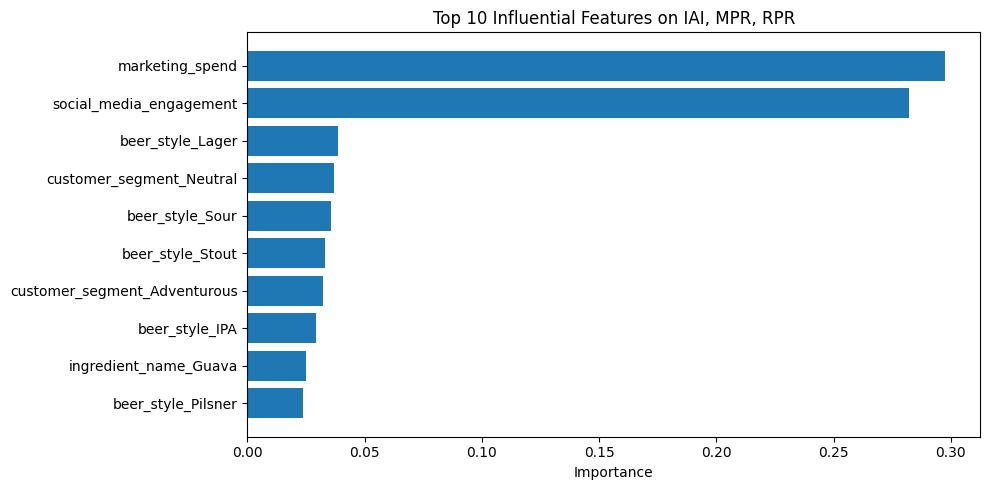

In [9]:
# Plot feature importances (optional)
plt.figure(figsize=(10, 5))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
plt.xlabel("Importance")
plt.title("Top 10 Influential Features on IAI, MPR, RPR")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("feature_importance.png")